In [74]:
import sys, os, re, gzip, json, pickle, shutil, random

import numpy as np

from scipy import stats
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [6]:
data_path = '../data'
myspace_mp3s_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_mp3s_path
genre_map_path = '%s/genre_map.pkl' % myspace_mp3s_path
mfcc_path = '%s/audio_features/mfcc' % data_path

#'rock', 'metal', 'dance', 'rap', 'pop', 'jazz', 'experimental', 'world', 'electronic', 'folk', 'punk', 'blues'
binary_genres = ['metal', 'classical']

lab_idx = {g:i for i,g in enumerate(binary_genres)}

In [17]:
genre_cts = {}
for genre in os.listdir(mfcc_path):
    genre_path = '%s/%s' % (mfcc_path, genre)
    genre_cts[genre] = len(os.listdir(genre_path))
    
min_recs = min([genre_cts[g] for g in binary_genres])   

for g in sorted(genre_cts, key=genre_cts.get, reverse=True):
    print(g, genre_cts[g])

rock 9535
alternative 7056
metal 6609
dance 3620
rap 3392
pop 3216
jazz 3118
hip_hop 2764
experimental 2624
other 2548
world 1611
electronic 1468
folk 1337
punk 1315
blues 1033
ambient 977
reggae 775
goth 514
acoustic 488
country 365
classical 357
house 298
spiritual 273
progressive 157
oldies 155
funk 108
spoken_word 101
easy_listening 86
bluegrass 40
industrial 32
showtunes 25
disco 18


In [3]:
with gzip.open(metadata_path, 'rt', encoding='utf-8') as fz:
    metadata = json.load(fz)

with open(genre_map_path, 'rb') as f:
    genre_map = pickle.load(f)
    
#example metadata
kys = list(metadata.keys())
ky=kys[0]
ky, metadata[ky]

('46/std_1f69563352d19cb0132334cd0d3adeaf.mp3',
 {'song_name': 'big_yellow_moon',
  'artist_name': 'bill_nelson',
  'mp3_zipname': '46',
  'mp3_filename': 'std_1f69563352d19cb0132334cd0d3adeaf.mp3',
  'genres': ['rock', 'electronica', 'alternative']})

In [10]:
def get_mfcc_lengths(mfcc_path, genres, max_recs):
    lens=[]
    
    for genre in binary_genres:
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        for fn in os.listdir(genre_path):
            fp = '%s/%s' % (genre_path, fn)
            mfcc = np.load(fp)
            lens.append(mfcc.shape[1])
            ct+=1
            if ct>=min_recs:
                break
                
    l = np.array(lens)
    
    return l

(9792.02380952381, 4837.91379828136)

(array([8.82483549e-06, 2.94161183e-06, 5.88322366e-06, 2.94161183e-05,
        2.35328946e-05, 4.41241774e-05, 4.70657893e-05, 2.94161183e-05,
        4.41241774e-05, 5.88322366e-05, 5.29490129e-05, 5.29490129e-05,
        4.41241774e-05, 5.88322366e-05, 6.47154602e-05, 8.82483549e-05,
        1.00014802e-04, 1.23547697e-04, 1.02956414e-04, 9.41315785e-05,
        7.64819076e-05, 1.02956414e-04, 1.05898026e-04, 1.02956414e-04,
        6.47154602e-05, 6.17738484e-05, 6.47154602e-05, 7.64819076e-05,
        4.70657893e-05, 3.23577301e-05, 3.52993419e-05, 1.47080591e-05,
        4.41241774e-05, 3.23577301e-05, 2.05912828e-05, 1.76496710e-05,
        1.47080591e-05, 2.94161183e-06, 1.17664473e-05, 1.17664473e-05,
        1.47080591e-05, 8.82483549e-06, 8.82483549e-06, 5.88322366e-06,
        1.17664473e-05, 2.94161183e-06, 0.00000000e+00, 2.94161183e-06,
        0.00000000e+00, 0.00000000e+00, 2.94161183e-06, 5.88322366e-06,
        2.94161183e-06, 0.00000000e+00, 2.94161183e-06, 0.000000

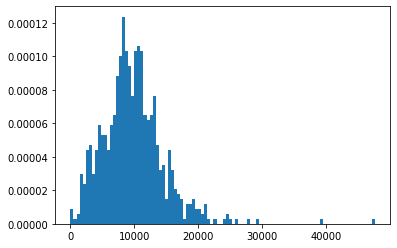

In [13]:
l = get_mfcc_lengths(mfcc_path, binary_genres, min_recs)

print('Mean mfcc length: %.4f, std: %.4f' % (l.mean(), l.std())) #9792.02380952381, 4837.91379828136

plt.hist(l, bins=100, density=True)
plt.show()

### Try different ways of dealing with the varying mfcc lengths

In [9]:
mfcc = np.load('%s/acoustic/msp_1_std_1b7ee19baed6ae4ea7332a60db0bcb4f.npy' % mfcc_path)

In [12]:
np.vstack([mfcc.mean(axis=1), mfcc.std(axis=1), stats.kurtosis(mfcc, axis=1), stats.skew(mfcc, axis=1)])

array([[-2.8108591e+02,  1.2224055e+02,  2.8064362e+01,  3.1553217e+01,
         1.5940080e+01,  1.3792233e+01,  4.4775543e+00,  5.4401940e-01,
        -8.0222225e+00, -9.0548048e+00, -7.3031354e+00, -8.1062689e+00,
        -9.4938993e+00, -7.5461569e+00, -9.5483360e+00, -1.1156130e+01,
        -1.2253296e+01, -7.0494881e+00, -7.5009913e+00, -6.9211936e+00],
       [ 8.6951828e+01,  2.9867422e+01,  1.9666704e+01,  1.4971158e+01,
         1.1757245e+01,  8.2338200e+00,  8.2472515e+00,  7.4393983e+00,
         7.9877319e+00,  1.0237029e+01,  8.3215666e+00,  7.6278958e+00,
         8.1165676e+00,  7.5231209e+00,  7.4042001e+00,  6.7408314e+00,
         6.5452747e+00,  6.6313405e+00,  7.7863317e+00,  7.5268083e+00],
       [-2.0438838e-01,  1.9405127e+00,  8.4137917e-01,  7.3870349e-01,
         7.7184796e-01,  5.1357436e-01,  1.5301127e+00,  9.4353080e-01,
         3.4467864e-01,  2.7901173e-02, -4.7985554e-02, -1.4419651e-01,
         7.4904442e-02, -1.5321231e-01,  2.5043797e-01,  5.465

In [20]:
def shuffle_data(x, y):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    
    return x, y


def normalize_data(x):
    return (x-x.mean())/x.std()


def get_col_stats(mfcc_path, genres, lab_idx, max_recs):
    mfccs = []
    y=[]
    
    for genre in genres:
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        for fn in os.listdir(genre_path):
            fp = '%s/%s' % (genre_path, fn)
            
            mfcc = np.load(fp)
            mfccs.append(np.hstack([mfcc.mean(axis=1), 
                                    mfcc.std(axis=1), 
                                    stats.kurtosis(mfcc, axis=1), 
                                    stats.skew(mfcc, axis=1)]))
            
            y.append(lab_idx[genre])
            
            ct+=1
            if ct>=max_recs:
                break
                
    x = np.array(mfccs)
    x = normalize_data(x)
    
    y = np.array(y)
    
    return shuffle_data(x, y)

                
def truncate_cols(mfcc_path, genres, lab_idx, col_len, max_recs):
    mfccs = []
    y=[]
    
    for genre in genres:
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        for fn in os.listdir(genre_path):
            fp = '%s/%s' % (genre_path, fn)
            
            mfcc = np.load(fp)[:,:col_len]
            mfccs.append(np.pad(mfcc, ((0,0),(0,col_len-mfcc.shape[1])), 'constant'))
            
            y.append(lab_idx[genre])
            
            ct+=1
            if ct>=max_recs:
                break
                
    x = np.array(mfccs)
    y = np.array(y)
                
    return shuffle_data(x, y)


def svd_reduce(x, n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    x = svd.fit_transform(x.reshape(x.shape[0], -1))
    print(x.shape, svd.explained_variance_ratio_.sum())
    
    return x

In [19]:
x, y = get_col_stats(mfcc_path, binary_genres, lab_idx, min_recs)
x.shape, y.shape

((714, 80), (714,))

In [23]:
num_test = x.shape[0]//5
x_train, x_test, y_train, y_test = x[num_test:], x[:num_test], y[num_test:], y[:num_test]

### Different models

#### Col_stats, Logistic Regression

In [28]:
from sklearn.metrics import classification_report

In [73]:
log_reg = LogisticRegression(C=1.0, max_iter=1000)

clf = log_reg.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
#0.91

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        72
           1       0.95      0.86      0.90        70

    accuracy                           0.91       142
   macro avg       0.91      0.91      0.91       142
weighted avg       0.91      0.91      0.91       142



#### Col_stats, LinearSVM

In [33]:
lin_svm = LinearSVC(C=1.0, loss='hinge', max_iter=10000)

clf = lin_svm.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
#0.92

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        72
           1       0.93      0.90      0.91        70

    accuracy                           0.92       142
   macro avg       0.92      0.92      0.92       142
weighted avg       0.92      0.92      0.92       142



#### Col_stats, SVM

In [44]:
svm = SVC(C=1.0, kernel='sigmoid', gamma='scale')

clf = svm.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))

#poly, degree 2: 0.89
#poly, degree 3: 0.88
#rbf: 0.9
#sigmoid: 0.83

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        72
           1       0.84      0.81      0.83        70

    accuracy                           0.83       142
   macro avg       0.83      0.83      0.83       142
weighted avg       0.83      0.83      0.83       142



#### MLP

In [71]:
mlp = MLPClassifier(hidden_layer_sizes=(10), solver='adam', max_iter=2500)

clf = mlp.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))

#adam
#hid 3 : 0.91
#hid 5 : 0.92
#hid 10 : 0.92
#hid 20 : 0.91
#hid 50 : 0.91
#hid 100 : 0.91
#hid 200 : 0.91
#hid 500 : 0.90
#hid 5,5 : 0.88
#hid 10,5 : 0.89
#hid 20,10 : 0.9
#hid 100,50 : 0.89

#sgd always did a bit worse than adam, lbfgs did even worse

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        72
           1       0.84      0.84      0.84        70

    accuracy                           0.85       142
   macro avg       0.85      0.85      0.85       142
weighted avg       0.85      0.85      0.85       142



####  = QuadraticDiscriminantAnalysis()

In [72]:
qda = QuadraticDiscriminantAnalysis()
    
clf = qda.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
#0.87

              precision    recall  f1-score   support

           0       0.90      0.85      0.87        72
           1       0.85      0.90      0.88        70

    accuracy                           0.87       142
   macro avg       0.87      0.87      0.87       142
weighted avg       0.87      0.87      0.87       142



#### Custom network

In [86]:
class MusicClassifier(nn.Module):
    def __init__(self, num_in, num_out):
        super(MusicClassifier, self).__init__()
        self.layer_1 = nn.Linear(num_in, 256)
        self.layer_2 = nn.Linear(256, 256)
        self.layer_out = nn.Linear(256, num_out)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [98]:
lr = 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = MusicClassifier(x_train.shape[1], 1)
model.to(device)
model.train()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

cpu


In [117]:
def train_model(x, y, model, optimizer, criterion, batch_size, epochs, device):
    x_batches = [x[i*batch_size:(i+1)*batch_size] for i in range((x.shape[0]//batch_size) + 1)]
    y_batches = [y[i*batch_size:(i+1)*batch_size] for i in range((x.shape[0]//batch_size) + 1)]
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        
        idx = list(range(len(x_batches)))
        random.shuffle(idx)
        x_batches = [x_batches[i] for i in idx]
        y_batches = [y_batches[i] for i in idx]
        
        for x_batch, y_batch in zip(x_batches, y_batches):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        print('Epoch %d\tLoss: %.8f\tAcc: %.8f' % (epoch, epoch_loss/len(x_batches), epoch_acc/len(x_batches)))
        
    return model
        
        
def binary_acc(y_pred, y_test):
    y_pred = torch.round(torch.sigmoid(y_pred))

    cor = (y_pred == y_test).sum().float()
    acc = cor/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


def test(x_test, y_test, model):
    model.eval()
    y_preds = []

    with torch.no_grad():
        y_pred = model(x_test)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred).cpu().numpy()
        y_preds.append(y_pred)

    y_preds = [a.squeeze().tolist() for a in y_preds]
    y_preds = [int(y) for y in y_preds[0]]
    
    print(classification_report(y_test.tolist(), y_preds))

In [102]:
batch_size = 128
epochs = 50
model = train_model(torch.from_numpy(x), torch.from_numpy(y).float(), 
            model, optimizer, criterion, batch_size, epochs, device)

Epoch 1	Loss: 0.38558594	Acc: 80.50000000
Epoch 2	Loss: 0.24455492	Acc: 90.16666667
Epoch 3	Loss: 0.20625146	Acc: 91.50000000
Epoch 4	Loss: 0.18040086	Acc: 92.33333333
Epoch 5	Loss: 0.16888884	Acc: 93.33333333
Epoch 6	Loss: 0.15121719	Acc: 94.33333333
Epoch 7	Loss: 0.14243192	Acc: 93.66666667
Epoch 8	Loss: 0.13041150	Acc: 94.83333333
Epoch 9	Loss: 0.12027192	Acc: 95.50000000
Epoch 10	Loss: 0.11081885	Acc: 96.16666667
Epoch 11	Loss: 0.09795913	Acc: 96.16666667
Epoch 12	Loss: 0.08834397	Acc: 96.50000000
Epoch 13	Loss: 0.08013438	Acc: 97.16666667
Epoch 14	Loss: 0.07279375	Acc: 98.00000000
Epoch 15	Loss: 0.06219166	Acc: 98.33333333
Epoch 16	Loss: 0.05496892	Acc: 98.50000000
Epoch 17	Loss: 0.04779060	Acc: 98.50000000
Epoch 18	Loss: 0.03963955	Acc: 98.83333333
Epoch 19	Loss: 0.03275208	Acc: 99.00000000
Epoch 20	Loss: 0.02934855	Acc: 99.33333333
Epoch 21	Loss: 0.02517277	Acc: 99.66666667
Epoch 22	Loss: 0.01930327	Acc: 99.66666667
Epoch 23	Loss: 0.01619601	Acc: 99.83333333
Epoch 24	Loss: 0.014

In [118]:
test(torch.from_numpy(x_test).to(device), torch.from_numpy(y_test).float().to(device), model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        72
         1.0       1.00      1.00      1.00        70

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



#### CNN for padded raw mfccs